In [5]:
import os
import cv2
import random
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import MinMaxScaler
import math

# Extract annotations from json file
def extract_annotations(json_file_path):
    annotations = []
    
    with open(json_file_path, 'r') as f:
        data = json.load(f)
        
        for item in data:
            annotation = item["bbox"]
            annotations.append(annotation)
            
    return annotations

# Perform sliding window technique
def sliding_window(image, window_size, stride):
    windows = []
    for y in range(0, image.shape[0], stride):
        for x in range(0, image.shape[1], stride):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            windows.append(((x, y), window))
    return windows

# Check if the window contains the object specified by the annotations
def window_contains(x, y, window_size, boundary):
    bx1, by1, bx2, by2 = boundary
    x_end = x + window_size
    y_end = y + window_size
    bx_end = bx1 + bx2
    by_end = by1 + by2
    x_overlap = max(0, min(x_end, bx_end) - max(x, bx1))
    y_overlap = max(0, min(y_end, by_end) - max(y, by1))
    
    # If both x_overlap and y_overlap are positive, the boxes overlap
    if x_overlap > 10 and y_overlap > 10:
        return 1
    else:
        return 0

# Check if sample image contains too much white border
def check_border(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    total_pixels = gray_image.shape[0] * gray_image.shape[1]
    num_white_pixels = np.sum(gray_image == 255)
    white_percentage = (num_white_pixels / total_pixels) * 100
    return white_percentage < 10

Number of postive samples:500
Number of negative samples:931


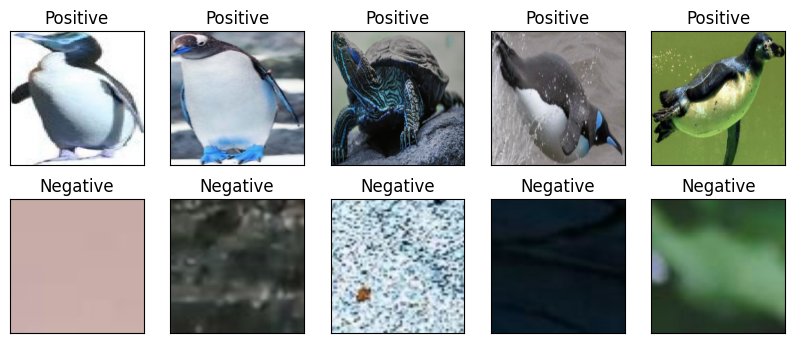

In [19]:
window_size = (64, 64)
image_size = (224, 224)
stride = 64

# Getting dataset
train_annotations = extract_annotations("datasets/train_annotations.json")
train_images_dir = 'datasets/train/images/'
train_pos = []
train_neg = []
train_index = 0
index = 0

# Create negative directory
negative_path = 'datasets/negatives'
if (not os.path.isdir(negative_path)):
    os.mkdir(negative_path)

# Create result directory
result_path = 'detection_results'
if (not os.path.isdir(result_path)):
    os.mkdir(result_path)

# Iterate images in datasets
for image_file in os.listdir(train_images_dir):
    image = cv2.imread(train_images_dir + image_file)

    # Getting boundaries
    x_min, y_min, width, height = train_annotations[train_index]
    train_index += 1
    x_max, y_max = x_min + width, y_min + height

    # Crop image to be added to positive set
    cropped_image = image[y_min:y_max, x_min:x_max]
    img = cv2.resize(cropped_image, image_size)
    train_pos.append(img)

    # If negative set does not exist
    if (not bool(os.listdir('datasets/negatives'))):

        # Extract background from original images to be added to negative set
        windows = sliding_window(image, window_size, stride)
        boundary = train_annotations[index]
        count = 0
        for window in windows:
            if count >= 5:
                break
            count += 1
            (x1, y1), img = window

            # Check if background does not contain object or white borders
            if (not window_contains(x1, y1, window_size[0], boundary) and check_border(img)):
                img = cv2.resize(img, image_size)
                train_neg.append(img)

        index += 1

# Save negative if it does not exist
if (not bool(os.listdir('datasets/negatives'))):
    index = 0
    for img in train_neg:
        image_path = 'datasets/negatives/neg_' + str(index) + '.jpg'
        cv2.imwrite(image_path, img)
        index += 1
else:
    # Else load negative set
    for image_file in os.listdir('datasets/negatives'):
        image = cv2.imread('datasets/negatives/' + image_file)
        train_neg.append(image)

num_images_to_display = 5
print('Number of postive samples:' + str(len(train_pos)))
print('Number of negative samples:' + str(len(train_neg)))


# Create a random sample of five elements from the sets
random_pos_sample = random.sample(train_pos, num_images_to_display)
random_neg_sample = random.sample(train_neg, num_images_to_display)
figure = plt.figure(figsize=(10, 4))

# Display the sampled images
for i in range(num_images_to_display):
    current_plot = figure.add_subplot(2, 5, i + 1)
    current_plot.set_title('Positive')
    current_plot.imshow(random_pos_sample[i])
    current_plot.set_xticks([])
    current_plot.set_yticks([])
    current_plot.set_xlabel('')
    current_plot.set_ylabel('')

for i in range(num_images_to_display):
    current_plot = figure.add_subplot(2, 5, i + 6)
    current_plot.set_title('Negative')
    current_plot.imshow(random_neg_sample[i])
    current_plot.set_xticks([])
    current_plot.set_yticks([])
    current_plot.set_xlabel('')
    current_plot.set_ylabel('')
plt.show()

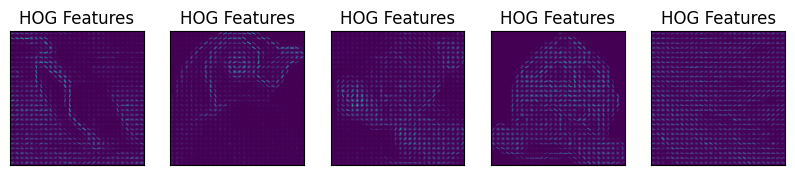

In [6]:
hog_X = []
hog_features = []
labels = []

# Extract HOG features in positive set
for img in train_pos:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_X.append(fd)
    hog_features.append(hog_image)
    labels.append(1)

# Extract HOG features in negative set
for img in train_neg:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)

    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_X.append(fd)
    hog_features.append(hog_image)
    labels.append(0)

random_sample = random.sample(hog_features, num_images_to_display)
figure = plt.figure(figsize=(10, 4))

#Display the feature images
for i in range(num_images_to_display):
    current_plot = figure.add_subplot(2, 5, i + 1)
    current_plot.set_title('HOG Features')
    current_plot.imshow(random_sample[i])
    current_plot.set_xticks([])
    current_plot.set_yticks([])
    current_plot.set_xlabel('')
    current_plot.set_ylabel('')
plt.show()

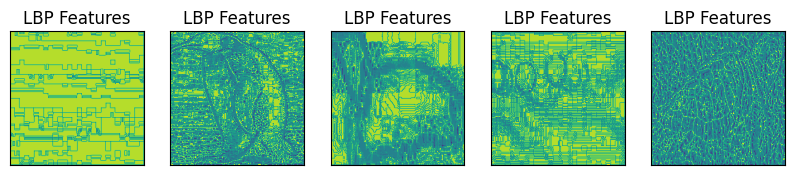

In [7]:
# Radius for LBP
radius = 1
# Number of neighbors to consider for LBP
n_points = 8 * radius 


lbp_X = []
lbp_features = []
labels = []

# Extract LBP features in positive set
for img in train_pos:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)
    lbp = local_binary_pattern(img, n_points, radius, 'uniform')
    fd = lbp.flatten()
    lbp_X.append(fd)
    lbp_features.append(lbp)
    labels.append(1)

# Extract LBP features in negative set
for img in train_neg:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)
    lbp = local_binary_pattern(img, n_points, radius, 'uniform')
    fd = lbp.flatten()
    lbp_X.append(fd)
    lbp_features.append(lbp)
    labels.append(0)

random_sample = random.sample(lbp_features, num_images_to_display)
figure = plt.figure(figsize=(10, 4))

# Display the feature images
for i in range(num_images_to_display):
    current_plot = figure.add_subplot(2, 5, i + 1)
    current_plot.set_title('LBP Features')
    current_plot.imshow(random_sample[i])
    current_plot.set_xticks([])
    current_plot.set_yticks([])
    current_plot.set_xlabel('')
    current_plot.set_ylabel('')
plt.show()

In [8]:
# Combine features
combined_X = np.hstack((hog_X, lbp_X))
X_train, X_test, y_train, y_test = train_test_split(combined_X, labels, test_size=0.2, random_state=42)
combined_clf = svm.SVC()
combined_clf.fit(X_train, y_train)

# Predict on the test features, print the results
combined_y_pred = combined_clf.predict(X_test)
print("HOG + LBP Accuracy: "+str(accuracy_score(y_test, combined_y_pred)))
print('\n')
print(classification_report(y_test, combined_y_pred))

HOG + LBP Accuracy: 0.8020833333333334


              precision    recall  f1-score   support

           0       0.98      0.62      0.76        97
           1       0.72      0.99      0.83        95

    accuracy                           0.80       192
   macro avg       0.85      0.80      0.80       192
weighted avg       0.85      0.80      0.80       192



In [9]:
class Heatmap():
    
    # Initialise heatmap
    def __init__(self,original_image):
        self.mask = np.zeros(original_image.shape[:2])
    
    # Add value to region
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Remove value from region
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    # Compile final heatmap
    def compileHeatmap(self):
        scaler = MinMaxScaler()
        self.mask = scaler.fit_transform(self.mask)
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [10]:
# Function to detect object
def detect(image):
    # Create heatmap
    htmp = Heatmap(image)

    # Sliding window
    windows = sliding_window(image, window_size, stride)

    for window in windows:
        # Extract features from window
        (x1, y1), img = window
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, image_size)
        lbp = local_binary_pattern(img, n_points, radius, 'uniform')
        lbp_fd = [lbp.flatten()]
        img = cv2.resize(img, image_size)
        hog_fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_fd = [hog_fd]
        flattened_patch = np.hstack((hog_fd, lbp_fd))

        # Make the prediction using the SVM model
        prediction = combined_clf.predict(flattened_patch)[0]
        coords = (x1, y1, x1 + window_size[0], y1 + window_size[0])

        # If object is detect add heat to map
        if prediction == 1:
            htmp.incValOfReg(coords)
        # Else remove heat from map
        else:
            htmp.decValOfReg(coords)
        
    # Compiling heatmap
    mask = htmp.compileHeatmap()

    # Find contours in map and get coords
    cont,_ = cv2.findContours(mask,1,2)[:2]
    if (not len(cont)):
        return (0,0,0,0), image
    c = cont[0]
    result_coord = cv2.boundingRect(c)
    (x,y,w,h) = result_coord

    # Draw box in image and return result
    image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    return result_coord, image
    
window_size = (64, 64)
stride = 32

result = []
result_coord = []

# Get valid dataset
valid_annotations = extract_annotations("datasets/valid_annotations.json")
valid_images_dir = 'datasets/valid/images/'
train_pos = []
train_neg = []

# Detect boxes in set
for image_file in os.listdir(valid_images_dir):
    image = cv2.imread(train_images_dir + image_file)
    print(image_file)
    res_coord, res_img = detect(image)
    result.append(res_img)
    result_coord.append(res_coord)

    

image_id_000.jpg


image_id_001.jpg
image_id_002.jpg
image_id_003.jpg
image_id_004.jpg
image_id_005.jpg
image_id_006.jpg
image_id_007.jpg
image_id_008.jpg
image_id_009.jpg
image_id_010.jpg
image_id_011.jpg
image_id_012.jpg
image_id_013.jpg
image_id_014.jpg
image_id_015.jpg
image_id_016.jpg
image_id_017.jpg
image_id_018.jpg
image_id_019.jpg
image_id_020.jpg
image_id_021.jpg
image_id_022.jpg
image_id_023.jpg
image_id_024.jpg
image_id_025.jpg
image_id_026.jpg
image_id_027.jpg
image_id_028.jpg
image_id_029.jpg
image_id_030.jpg
image_id_031.jpg
image_id_032.jpg
image_id_033.jpg
image_id_034.jpg
image_id_035.jpg
image_id_036.jpg
image_id_037.jpg
image_id_038.jpg
image_id_039.jpg
image_id_040.jpg
image_id_041.jpg
image_id_042.jpg
image_id_043.jpg
image_id_044.jpg
image_id_045.jpg
image_id_046.jpg
image_id_047.jpg
image_id_048.jpg
image_id_049.jpg
image_id_050.jpg
image_id_051.jpg
image_id_052.jpg
image_id_053.jpg
image_id_054.jpg
image_id_055.jpg
image_id_056.jpg
image_id_057.jpg
image_id_058.jpg
image_id_059.j

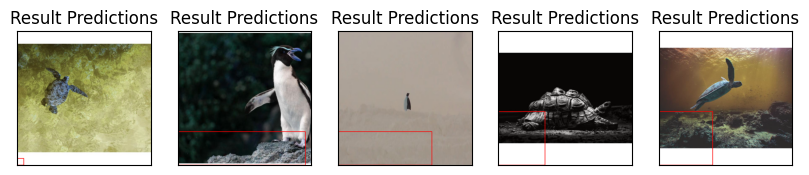

In [22]:
# Save result images
index = 0
for img in result:
    image_path = 'detection_results/result' + str(index) + '.jpg'
    cv2.imwrite(image_path, img)
    index += 1

random_sample = random.sample(result, num_images_to_display)
figure = plt.figure(figsize=(10, 4))

# Display the sampled result images
for i in range(num_images_to_display):
    current_plot = figure.add_subplot(2, 5, i + 1)
    current_plot.set_title('Result Predictions')
    current_plot.imshow(random_sample[i])
    current_plot.set_xticks([])
    current_plot.set_yticks([])
    current_plot.set_xlabel('')
    current_plot.set_ylabel('')
plt.show()

In [14]:
# Calculate IOU value
def iou(y_true, y_pred):
    x_min_true, y_min_true, x_max_true, y_max_true = y_true
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = y_pred

    x_min_intersect = max(x_min_true, x_min_pred)
    y_min_intersect = max(y_min_true, y_min_pred)
    x_max_intersect = min(x_max_true, x_max_pred)
    y_max_intersect = min(y_max_true, y_max_pred)

    # Get interstection
    intersection_area = max((x_max_intersect - x_min_intersect), 0) * max((y_max_intersect - y_min_intersect), 0)

    # Get union
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union_area = true_area + pred_area - intersection_area

    iou = intersection_area / (union_area)

    return iou

# Calculate distance value
def dist(y_true, y_pred):

    # Get centre values
    x_min_true, y_min_true, x_max_true, y_max_true = y_true
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = y_pred
    x1_cent = x_min_true + (x_max_true/2)
    y1_cent = y_min_true + (y_max_true/2)

    x2_cent = x_min_pred + (x_max_pred/2)
    y2_cent = y_min_pred + (y_max_pred/2)

    return math.sqrt((x2_cent - x1_cent)**2 + (y2_cent - y1_cent)**2)

# Compute standard deviation values
dist_values = []
iou_values = []
for i in range(len(result_coord)):
    iou_values.append(iou(result_coord[i], valid_annotations[i]))
    dist_values.append(dist(result_coord[i], valid_annotations[i]))
print('Standard Deviation IOU: ' + str(np.std(iou_values)))
print('Standard Deviation Distance: ' + str(np.std(dist_values)))

Standard Deviation IOU: 0.06499660111521426
Standard Deviation Distance: 96.62611530527963
